# Тема курсовой: обучение модели классификации для прогнозирования не выполнения долговых обязательств по текущему кредину.

## 1. Подготовка ноутбука

In [1]:
# Подключаем библиотеки

import pandas as pd
import numpy as np

from scipy.stats import shapiro, ttest_rel, chi2_contingency

from sklearn.metrics import f1_score, r2_score, mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inlinebackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

##### Функции для подготовки данных

In [2]:
def sampling(df: pd.DataFrame, target: str, columns: list, final=False) -> tuple:
    """Функция для разбиения данных"""
    
    # сплитим на X и y
    df = df[columns]
    
    Xy_df = df[df[target].notna()]
    
    X = Xy_df.drop(target, axis=1)
    y = Xy_df[target]

    # сплитим на train и test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if final:
        final = df[df[target].isna()]
        final = final.drop(target, axis=1)
        return X_train, X_test, y_train, y_test, final
    elif not final:
        return X_train, X_test, y_train, y_test

In [3]:
def pred_feature(df, target, columns, max_depth, learning_rate, n_estimators, random_state=42):
    """Функция для обучения LGBM"""
    
    # сплитим на train и test
    X_train, X_test, y_train, y_test, final = sampling(df=df, target=target, columns=columns, final=True)
        
    # обучаем модель
    xgb_model = LGBMRegressor(max_depth=max_depth, learning_rate=learning_rate, 
                              n_estimators=n_estimators, random_state=random_state)
    xgb_model.fit(X_train, y_train)

    # предсказываем зачения
    y_train_pred = xgb_model.predict(X_train)
    y_test_pred = xgb_model.predict(X_test)

    # смотрим результат
    print(target)
    evaluation_result(y_train=y_train, y_train_pred=y_train_pred, y_test=y_test, y_test_pred=y_test_pred)
        
    df_pred = pd.DataFrame()
    df_pred[target] = xgb_model.predict(final)
    df_pred = df_pred.set_index(final.index)
        
    return df_pred, xgb_model

In [4]:
def balancing(df, target_name):
    """функция для балансировки значений"""

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [5]:
# Формируем пути до данных

# PATH_TO_TRAIN = '../input/course-project/course_project_train.csv'
# PATH_TO_TEST = '../input/course-project/course_project_test.csv'

PATH_TO_TRAIN = 'course_project_train.csv'
PATH_TO_TEST = 'course_project_test.csv'

## 2. Анализ датасетов

##### Функции для анализа

In [6]:
def missing_data(df: pd.DataFrame) -> pd.Series:
    """get dataframe and calculate emissions in its data in percentage"""
    
    featur_counts = df.count()
    object_counts = df.shape[0]
    
    calc_procent = (1 - featur_counts/object_counts) * 100
    
    feature_procent = round(calc_procent, 2)
            
    result = {i: f'{v}%' for i, v in feature_procent.items() if v != 0}
    
    return pd.Series(result)

In [7]:
def correlation(
    df: pd.DataFrame, 
    target: str
) -> (print, plt.plot):
    """calculates correlation whith target and plots graph"""
    
    corr_table = df.corr()
    
    result = corr_table.drop([target], axis=0) if target != None else corr_table
    sort_values = result.sort_values(target, ascending=False)*100 if target != None else result
    
    coef = round(sort_values[target], 2)
    
    print(coef)
    
    plt.figure(figsize=(12,4))

    plt.barh(coef.index, coef.values)

    plt.title(f'Correlation with {target}', fontsize=16)
    plt.xlabel('percent', fontsize=14)
    
    plt.grid()

In [8]:
def emission(
    series: pd.Series, 
    val: int = None
) -> print:
    """
    get series and shop emissions in it, 
    if val then can calculate emissions and is percent
    """
    
    print(
        f'min = {series.min()}\n'
        f'max = {series.max()}\n'
        f'mean = {series.mean()}'
    )
    if val != None:
        em = series > val

        print(
            f'Число выбрасов = {em.sum()}\n'
            f'Процент выбрасов = {round(em.sum() / series.shape[0] * 100, 2)}%'
        )
        
    plt.scatter(series.index, series.values)
    plt.plot()

In [9]:
def chi2_test(df, feature, values, target='Credit Default'):
    """функция для проверги гиппотез на синхронность"""
    
    alpha=0.5
    
    df = df[df[feature].notna()][:1000]

    df1 = df[df[feature] == values[0]]
    test1 = df1[target].value_counts()

    df2 = df[df[feature] == values[1]]
    test2 = df2[target].value_counts()
    
    p = chi2_contingency([test1, test2])[1]
    print(f'p = {p}')
    
    if p <= alpha:
        print(f'{values[0]} != {values[1]}, при alpha = {alpha}') 
    elif p > alpha:
        print(f'{values[0]} == {values[1]}, при alpha = {alpha}')

In [10]:
def shapiro_test(feature: pd.Series) -> print:
    """функция для проверги гиппотез на нормальность"""
    
    
    alpha = 0.5
    result = shapiro(feature[:1000])
    
    p = result[1]
    print(f'p = {p}')
    
    if p <= alpha:
        print(f'не имеет нормального распредение при alpha = {alpha}')
    elif p > alpha:
        print(f'имеет нормального распредение при alpha = {alpha}')

In [11]:
def evaluation_result(y_train, y_train_pred, y_test, y_test_pred, show=True):
    """функция для оценки результатов обучения"""
    
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    print(
        'R2:\n',
        f'train = {r2_train}\n',
        f'test = {r2_test}'
    )

    if show:
        fig, ax = plt.subplots(nrows=1, ncols=2)
        ax1, ax2 = ax

        ax1.scatter(y_train, y_train_pred)
        ax1.set_title(f'r2_train = {round(r2_train, 3)}')
        ax1.set_xlabel('true')
        ax1.set_ylabel('pred')

        ax2.scatter(y_test, y_test_pred)
        ax2.set_title(f'r2_test = {round(r2_test, 3)}')
        ax2.set_xlabel('true')
        ax2.set_ylabel('pred')

        fig.set_size_inches(12, 4)
        plt.subplots_adjust(wspace=0.4, hspace=0.1)
        plt.show()

In [12]:
def evaluation_classification(y_train_true, y_train_pred, y_test_true, y_test_pred):
    
    f1_train = f1_score(y_true=y_train_true, y_pred=y_train_pred)
    f1_test = f1_score(y_true=y_test_true, y_pred=y_test_pred)
    diff = f1_train - f1_test
    
    print(
        f'f1 score:\n',
        f'\ttrain = {round(f1_train, 2)}\n',
        f'\ttest = {round(f1_test, 2)}\n\n',
        f'\tdiff = {round(diff, 2)}'
    )

In [13]:
def plot_outliers(df_train, df_test, col_name, hist = False):
    
    fig, ax = plt.subplots(1,3,figsize=(16,5))
    ax[1].set_title('Train Dataset')
    ax[2].set_title('Test Dataset')
    sns.distplot(df_train[col_name], color='b', ax=ax[0], hist=hist, label='Train')
    sns.distplot(df_test[col_name], color='r', ax=ax[0], hist=hist, label='Test')
    sns.boxplot(df_train[col_name], ax=ax[1])
    sns.boxplot(df_test[col_name], color='r', ax=ax[2])
    plt.show()

##### Описание датасета

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

##### Xy_df

In [14]:
Xy_df = pd.read_csv(PATH_TO_TRAIN)
Xy_df.head(2)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1


In [15]:
# Состояние данных

Xy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

Видно что в некоторых фичах есть __пропуски__

In [16]:
# Просмотрим их целостность в процентнах:

missing_data(df=Xy_df)

Annual Income                   20.76%
Years in current job             4.95%
Months since last delinquent    54.41%
Bankruptcies                     0.19%
Credit Score                    20.76%
dtype: object

Видно что в некоторых фичах отсутствует __очень большое__ количество данных, от 5% до 54,5%

In [17]:
# Просмотрим сводку

Xy_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Credit Score                    44.21
Number of Open Accounts          2.89
Tax Liens                        2.44
Number of Credit Problems        2.01
Monthly Debt                     1.85
Months since last delinquent     0.26
Bankruptcies                     0.16
Maximum Open Credit             -1.43
Current Credit Balance          -1.95
Years of Credit History         -2.06
Annual Income                  -10.14
Current Loan Amount            -22.65
Name: Credit Default, dtype: float64


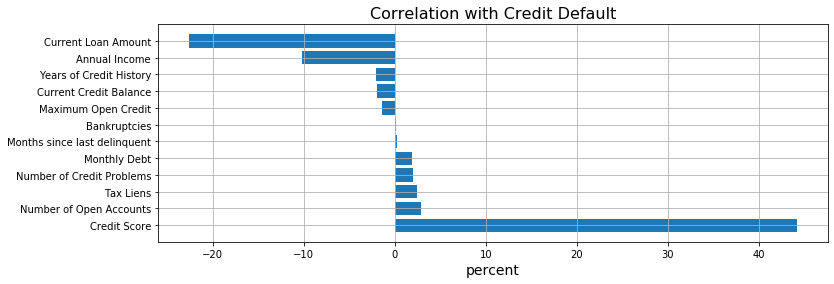

In [18]:
# Посмотрим корреляцию с таргером

correlation(df=Xy_df, target='Credit Default')

- Наибольшая __прямая зависимость__ с таргером наблюдается у _Credit Score_ = 44%<br>

(Скорее всего это __выбросы__, так как высокий __рейтинг__ не может совпадать с __не выполнением__ кредитвых обязательств.)

- Наибольшая __обратная зависимость__ наблюдается у _Current Load Amount_ = -23%<br> 

(Т.е. __высокий доход__ совпадает с __надежностью клиента__ по выполнению кредитных обязательств.)

##### X_Final

In [19]:
X_final = pd.read_csv(PATH_TO_TEST)
X_final.head(2)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0


In [20]:
# Состояние данных

X_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
Home Ownership                  2500 non-null object
Annual Income                   1987 non-null float64
Years in current job            2414 non-null object
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    1142 non-null float64
Bankruptcies                    2497 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    1987 non-null float64
dtypes: float64(12), object(4)
me

Видно что в некоторых фичах есть __пропуски__

In [21]:
# Просмотрим их процентное соотношение:

missing_data(df=X_final)

Annual Income                   20.52%
Years in current job             3.44%
Months since last delinquent    54.32%
Bankruptcies                     0.12%
Credit Score                    20.52%
dtype: object

Так же как и в train видно, что в некоторых фичах отсутствует __очень большое__ количество данных, от 3,5% до 54%

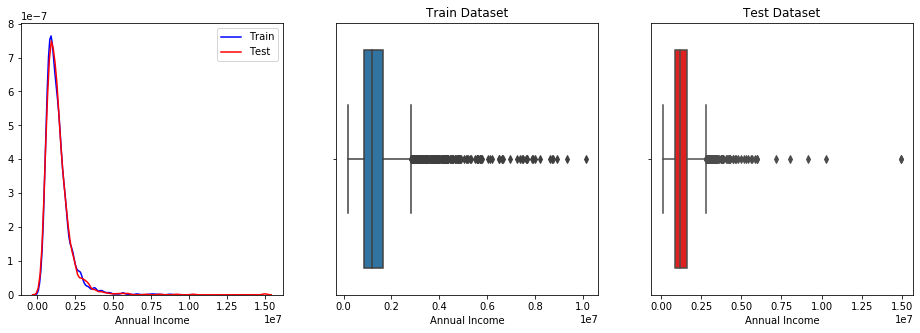

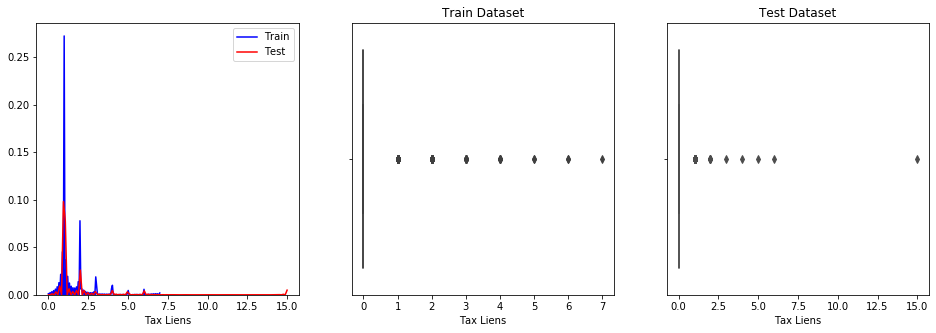

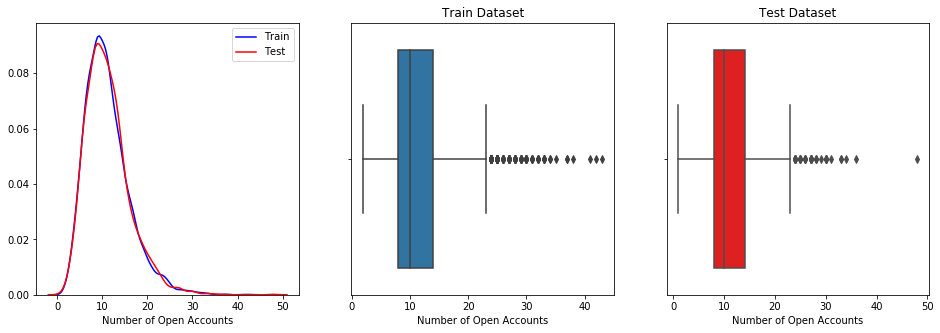

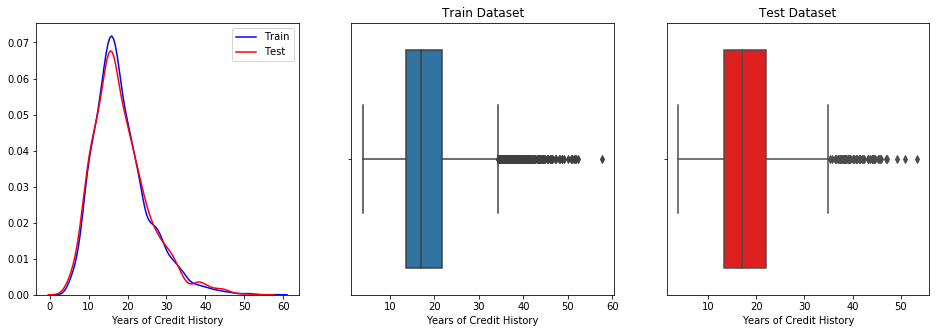

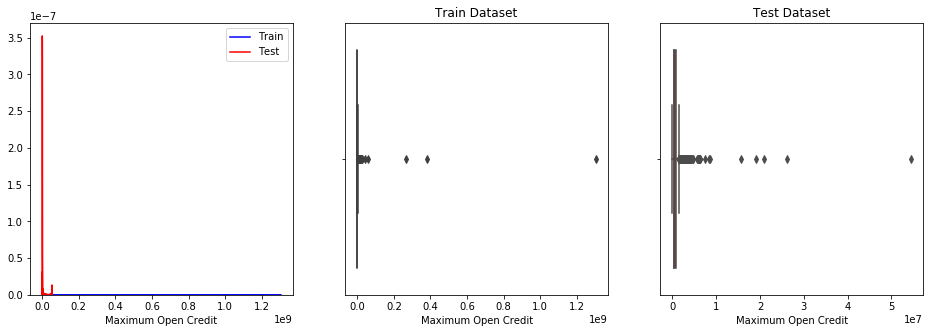

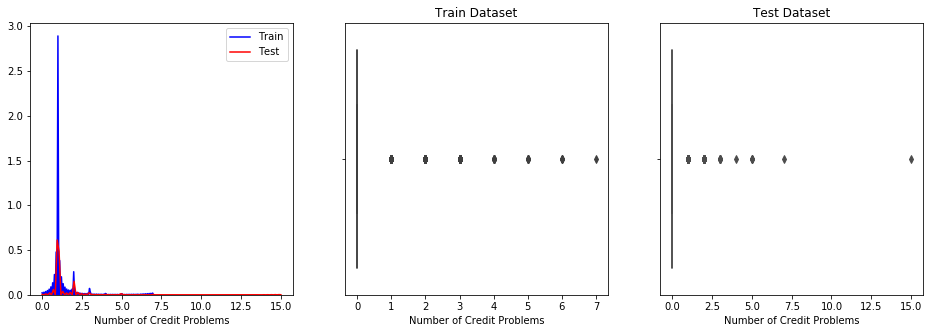

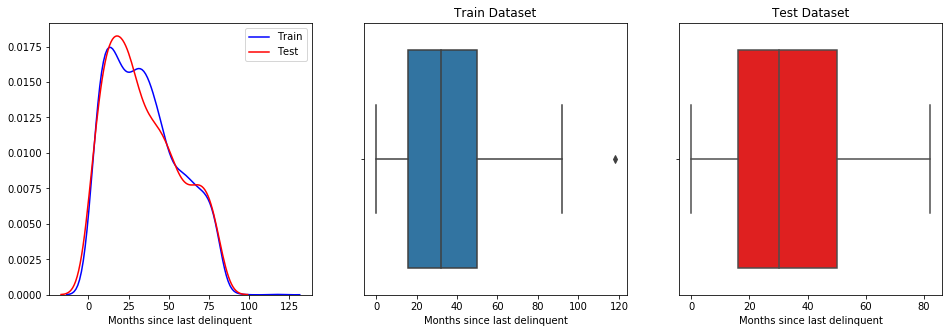

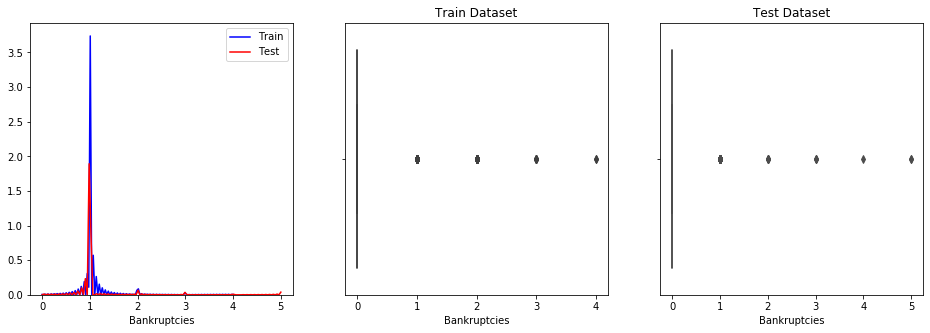

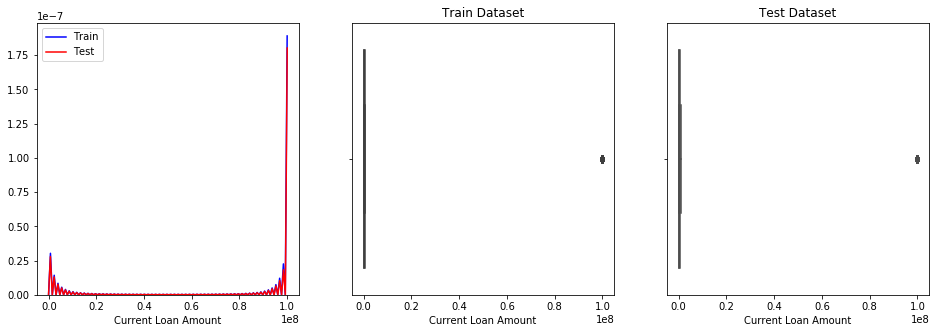

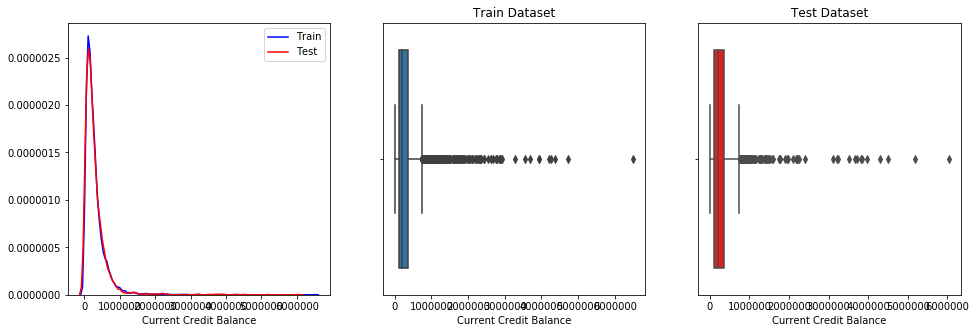

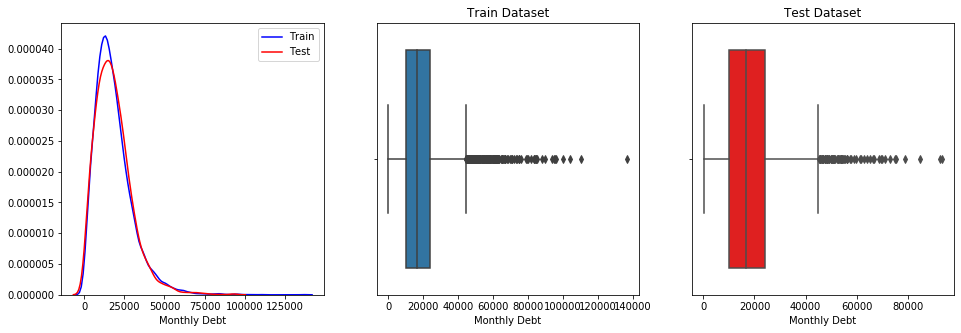

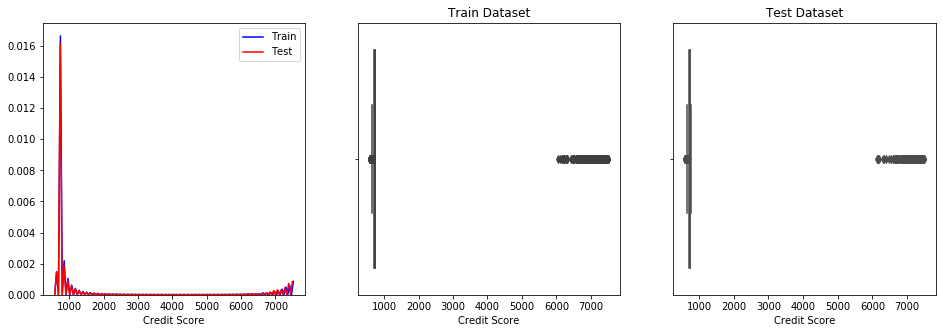

In [22]:
# Сопоставим данные в train и test
cont_cols = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 
             'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 
             'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

for col in cont_cols:
    plot_outliers(Xy_df, X_final, col)

Видны расхождения в дынных по некоторым признакам

## 3. Обработка данных

In [23]:
class Preprocessing:
    """Класс для предобработки данных"""
    
    def __init__(self, df, features):
        
        self.features = features
        self.df = df.copy()
        
        self.missMSLD = 'Изначально пуст'
        self.missBankruptcies = 'Изначально пуст'
        self.emmissMOC = 'Изначально пуст'
        self.model = 'Изначально пуст'
        
    def concat_values(self):
        """Объединение значений"""
        
        df = self.df
        
        df.loc[df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
        df.loc[df['Home Ownership'] == 'Rent', 'Home Ownership'] = 'Own Home'
        
    def mark(self):
        """Пометка ошибок в данных"""
        
        df = self.df
        
        df.loc[df['Current Loan Amount'] < 2e7, 'emissionsCLA'] = 0
        df.loc[df['Current Loan Amount'] > 2e7, 'emissionsCLA'] = 1
        
        df.loc[df['Credit Score'] <= 999, 'errorsCS'] = 0
        df.loc[df['Credit Score'] > 999, 'errorsCS'] = 1
        df.loc[df['Credit Score'].isna(), 'errorsCS'] = 2
        
        df.loc[df['Annual Income'].notna(), 'omissionsAI'] = 0
        df.loc[df['Annual Income'].isna(), 'omissionsAI'] = 1
        
    def retype_in_float(self):
        """Ретипизация данных из строк в категории"""
    
        df = self.df
        
        df['Home Ownership'] = df['Home Ownership'].map({'Home Mortgage': 0, 'Own Home': 1}).astype(float)
        df['Term'] = df['Term'].map({'Short Term': 0, 'Long Term':1}).astype(float)
        
    def missingMSLD(self):
        """заполнение пропусков суммой пропусков"""
        
        df = self.df
        
        self.missMSLD = (df['Months since last delinquent'].isna()).sum()
        
        df.loc[df['Months since last delinquent'].isna(), 'Months since last delinquent'] = self.missMSLD
        
    def missingBankruptcies(self):
        """заполнение пропусков медианой"""
        
        df = self.df
        
        self.missBankruptcies = df['Bankruptcies'].quantile(q=0.5)
        
        df.loc[df['Bankruptcies'].isna(), 'Bankruptcies'] = self.missBankruptcies
        
    def missingAnIn(self):
        """заполнение пропусков при помощи LGBM"""
        
        df = self.df

        target='Annual Income'
        
        columns = ['Annual Income', 'Home Ownership', 'Tax Liens', 'Number of Open Accounts', 'Maximum Open Credit', 
                   'Number of Credit Problems', 'Months since last delinquent', 'Current Loan Amount', 
                   'Current Credit Balance', 'Monthly Debt', 'Credit Score']
        
        pred, self.model = pred_feature(df=df, target=target, columns=columns, 
                                        max_depth=1, learning_rate=0.2, n_estimators=1950)
        df.loc[df[target].isna(), target] = pred
        
    def missingCrSc(self):
        """заполнение пропусков при помощи LGBM"""
        
        df = self.df
        
        target = 'Credit Score'
        
        columns = ['Credit Score', 'Term', 'Current Loan Amount', 'Home Ownership', 'Annual Income', 
                   'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 
                   'Months since last delinquent', 'Bankruptcies', 'Current Credit Balance', 'Monthly Debt', 
                   'errorsCS', 'Number of Open Accounts']
        
        pred, self.model = pred_feature(df=df, target=target, columns=columns, 
                                        max_depth=1, learning_rate=0.1, n_estimators=1300)
        df.loc[df[target].isna(), target] = pred
        
    def emissionsCS(self):
        """обработка выбросов путем деления на 10"""
        
        df = self.df
        
        df.loc[df['Credit Score']>999, 'Credit Score'] = df.loc[df['Credit Score']>999, 'Credit Score'] / 10
        
    def emissionsMOC(self):
        """Обработка выбросов средним значением"""
        
        df = self.df
        
        self.emmissMOC = df['Maximum Open Credit'].mean()
        
        df.loc[df['Maximum Open Credit'] > 2e8, 'Maximum Open Credit'] = self.emmissMOC
        
    def emissionsCLA(self):
        """заполнение пропусков при помощи LGBM"""
        
        df = self.df
        
        target = 'Current Loan Amount'
        
        columns = ['Current Loan Amount', 'Annual Income', 'Maximum Open Credit', 'Term', 'Current Credit Balance', 
                   'Number of Open Accounts', 'Years of Credit History', 'Credit Score']
        
        df.loc[df[target] > 2e7, target] = np.nan
        
        pred, self.model = pred_feature(df=df, target=target, columns=columns, 
                                        max_depth=1, learning_rate=0.1, n_estimators=490)
        df.loc[df[target].isna(), target] = pred
        
    def standard_data(self):
        """Стандартизация данных"""
        
        df = self.df
        
        scaler = StandardScaler()
        df[self.features] = scaler.fit_transform(df[self.features])

        
    def fit(self):
        """Порядок выполнения"""
        self.concat_values()
        self.mark()
        self.retype_in_float()

        self.missingMSLD()
        self.missingBankruptcies()

        self.emissionsCS()
        self.emissionsMOC()

        self.missingAnIn()
        self.missingCrSc()

        self.emissionsCLA()
        self.standard_data()
    
    def transform(self):
        pass

### Отбор признаков

In [24]:
# разобъем пригнаки 
TARGET_NAME = 'Credit Default'
FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 
                 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 
                 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Term', 'Home Ownership']

# инициализируем класс предобработки
xy_prep = Preprocessing(df=Xy_df, features=FEATURE_NAMES)

### Проверка гипотез

##### Нормальность

- Просмотрим график __Annual Income__

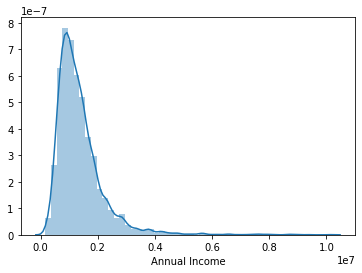

In [25]:
annInc = Xy_df[Xy_df['Annual Income'].notna()]['Annual Income']

sns.distplot(annInc)
plt.show()

$H_0 -$ __Annual Income__ имеет нормальное распределение <br>
$H_1 -$ __Annual Income__ не имеет нормального распределения

In [26]:
shapiro_test(feature=annInc)

p = 1.8844925930263994e-32
не имеет нормального распредение при alpha = 0.5


$H_0 = H_1,\ H_0$ опровергнута

- Просмотрим график __Monthly Debt__

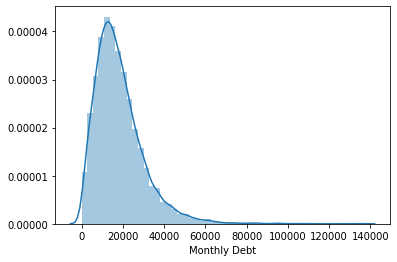

In [27]:
mountlyD = Xy_df['Monthly Debt']

sns.distplot(mountlyD)
plt.show()

$H_0 -$ __Monthly Debt__ имеет нормальное распределение<br>
$H_1 -$ __Monthly Debt__ не имеет нормального распределения

In [28]:
shapiro_test(feature=mountlyD)

p = 6.993885971736841e-25
не имеет нормального распредение при alpha = 0.5


$H_0 = H_1,\ H_0$ опровергнута

##### Синхронность

- Посмотрим график классов таргета в __Home Ownership__

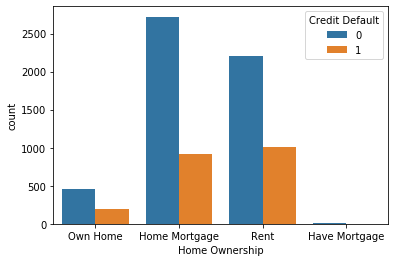

In [29]:
sns.countplot(x='Home Ownership', hue='Credit Default', data=Xy_df)
plt.show()

$H_0 -$ Home Morgage и Have Mortgage - cинхронны<br>
$H_1 -$ Home Morgage и Have Mortgage - не cинхронны

In [30]:
feature = 'Home Ownership'

values = 'Have Mortgage', 'Home Mortgage'
chi2_test(df=Xy_df, feature=feature, values=values)

values = 'Own Home', 'Rent'
chi2_test(df=Xy_df, feature=feature, values=values)

p = 0.7619804179070149
Have Mortgage == Home Mortgage, при alpha = 0.5
p = 0.7573724196801643
Own Home == Rent, при alpha = 0.5


Составим функций для объединения значений и применим

In [31]:
xy_prep.concat_values()

* ### Создание отметок и ретипизация (пропуски, выбросы, ретайпы)

In [32]:
xy_prep.mark() # пропуски и выбросы
xy_prep.retype_in_float() # ретайпы

### Первичная обработка пропусков

In [33]:
missing_data(df=Xy_df)

Annual Income                   20.76%
Years in current job             4.95%
Months since last delinquent    54.41%
Bankruptcies                     0.19%
Credit Score                    20.76%
dtype: object

- **Months since last delinquent** - количество месяцев с последней просрочки платежа

In [34]:
"""Судя по большому количеству пропусков в этом признаке можно сделать вывод, 
что они говорят об отсутствии просрочек по платежу, 
а значит посчитать количество месяцев не возможно.

Тогда заполним пропуски числом, которое будет показывать нам - сколько всего таких пропусков."""

xy_prep.missingMSLD()

- **Bankruptcies** - банкротство

In [35]:
"""Здесь ставнительно не много пропусков поэтому заполним их медиальным значением"""

xy_prep.missingBankruptcies()

### Первичная обработка выбросов

- **Credit Score** - кредитный рейтинг

min = 585.0
max = 7510.0
mean = 1151.0874978966851
Число выбрасов = 400
Процент выбрасов = 5.33%


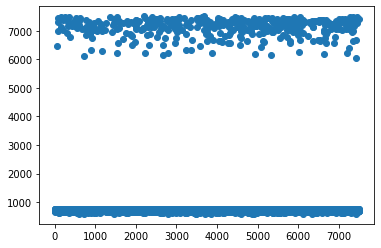

In [36]:
emission(
    series=Xy_df['Credit Score'], 
    val=999,
)

In [37]:
"""Зная, что максимальный кредитный рейтинг = 999, поделим выбросы на 10"""

xy_prep.emissionsCS()

- **Maximum Open Credit** - максимальная сумма кредита

min = 0.0
max = 1304726170.0
mean = 945153.7274666667
Число выбрасов = 3
Процент выбрасов = 0.04%


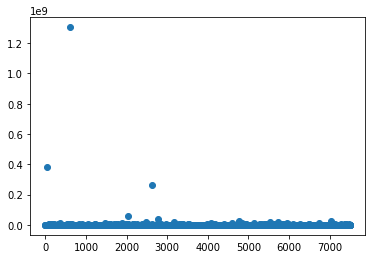

In [38]:
emission(
    series=Xy_df['Maximum Open Credit'],
    val=2e8
)

In [39]:
# Наблюдается 3 выброса, приведем их к среднему значению

xy_prep.emissionsMOC()

### Вторичная обработка пропусков

- **Annual Income** - годовой доход

Восстановим данные при помощи LightGBM

Annual Income
R2:
 train = 0.48896923596018405
 test = 0.4108604949536675


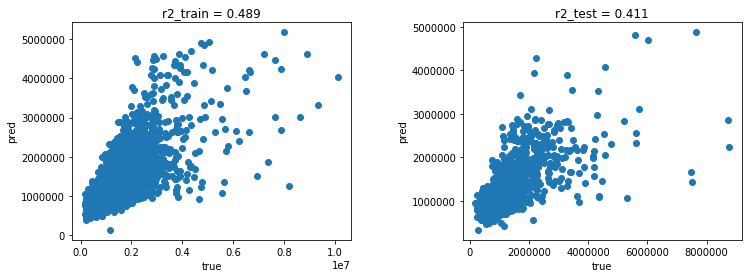

In [40]:
xy_prep.missingAnIn()

- **Credit Score** - кредитный рейтинг

Credit Score
R2:
 train = 0.36326740951754144
 test = 0.35728653757197404


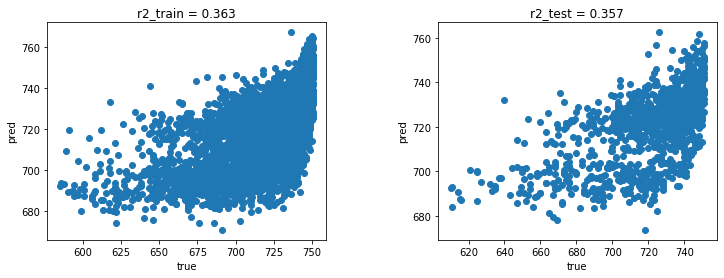

In [41]:
xy_prep.missingCrSc()

### Вторичная обработка выбрасов

- **Current Loan Amount** - текущая сумма кредита

min = 11242.0
max = 99999999.0
mean = 11873177.445066666
Число выбрасов = 870
Процент выбрасов = 11.6%


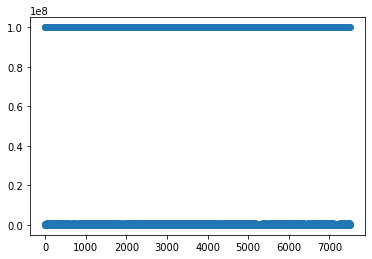

In [42]:
emission(
    series=Xy_df['Current Loan Amount'],
    val=2e7,
)

Обработаем выбросы при помощи LightGBM

Current Loan Amount
R2:
 train = 0.5058376815237862
 test = 0.5116308505775402


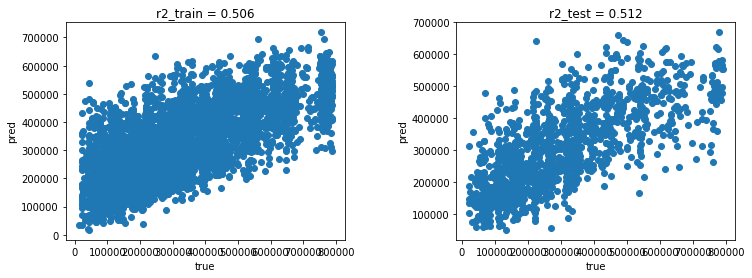

In [43]:
xy_prep.emissionsCLA()

Просмотрим результаты

Credit Score                    44.21
Number of Open Accounts          2.89
Tax Liens                        2.44
Number of Credit Problems        2.01
Monthly Debt                     1.85
Months since last delinquent     0.26
Bankruptcies                     0.16
Maximum Open Credit             -1.43
Current Credit Balance          -1.95
Years of Credit History         -2.06
Annual Income                  -10.14
Current Loan Amount            -22.65
Name: Credit Default, dtype: float64


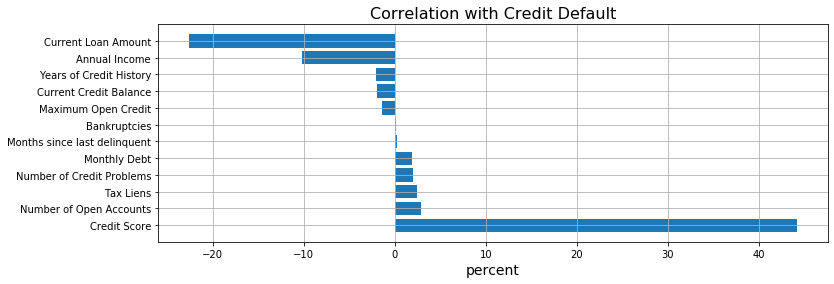

In [44]:
correlation(df=Xy_df, target='Credit Default')

## 4. Обучение модели

### Подготовка данных

In [45]:
# Отбор признаков
columns = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Maximum Open Credit', 'Number of Credit Problems', 
           'Term', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Credit Default', 'Current Loan Amount']

xy_prep.standard_data()

Xy = xy_prep.df
Xy = Xy[columns]

# Разбмение на X и y
X = Xy.drop('Credit Default', axis=1)
y = Xy['Credit Default']

# Разбиение на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42)

# # Балансировка классов
df_to_balansing = pd.concat([X_train, y_train], axis=1)

df_balanced = balancing(df=df_to_balansing, target_name=TARGET_NAME)

X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

##### Baseline

_LighGBM_

In [46]:
model_lgbm = LGBMClassifier(random_state=42)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

evaluation_classification(y_train, y_train_pred, y_test, y_test_pred)

f1 score:
 	train = 0.83
 	test = 0.41

 	diff = 0.43


_XGBoost_

In [47]:
model_xgb = XGBClassifier(random_state=42)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

evaluation_classification(y_train, y_train_pred, y_test, y_test_pred)

f1 score:
 	train = 0.95
 	test = 0.35

 	diff = 0.59


_CatBoost_

In [62]:
model_catb = CatBoostClassifier(iterations=640, learning_rate=0.1, depth=1, auto_class_weights='Balanced',
                                random_state=42, silent=True)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

evaluation_classification(y_train, y_train_pred, y_test, y_test_pred)

f1 score:
 	train = 0.61
 	test = 0.5

 	diff = 0.12
